# More EDA~ ✨🚀📊

## Setup

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"serotorianoparelphd","key":"6ebc5eacfa263c2757cde3ed2f8f1ad7"}'}

In [7]:
# Configure: Move uploaded file to required dir and set restricted permissions for security
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download subset ⏳

In [8]:
%%time
import kagglehub

# Download latest version of dataset
path = kagglehub.dataset_download("serotorianoparelphd/pilot-files-10users-1584")

print("Path to dataset files:", path)


100%|██████████| 21.2G/21.2G [16:30<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/serotorianoparelphd/pilot-files-10users-1584/versions/1
CPU times: user 5min 47s, sys: 1min 48s, total: 7min 36s
Wall time: 22min 46s


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from pathlib import Path
from collections import Counter

# Define Paths
DATA_DIR = Path(path) # path obtained from kagglehub.dataset_download

# Locate Metadata
METADATA_PATH = DATA_DIR / "metadata.csv"

# Check if path exists
if not METADATA_PATH.exists():
    print(f"Could not find {METADATA_PATH}")
    # List dir to see actual folder name if fail
    if DATA_DIR.exists():
        print("Files found in dataset:", os.listdir(DATA_DIR))
    else:
        print(f"The directory {DATA_DIR} was not found. Please check the 'Input' sidebar for the exact path.")
else:
    # Load metadata
    meta = pd.read_csv(METADATA_PATH)
    print(f"Metadata: {len(meta):,} rows, {meta['user'].nunique()} users, {meta['stage'].nunique()} stages")

Metadata: 25,253 rows, 193 users, 29 stages


In [10]:
# Verify pilot candidates: Calculate stats for all users
user_stats = meta.groupby('user').agg({
    'stage': 'nunique',       # Count unique stages
    'session': 'nunique',     # Count unique sessions
    'filename': 'count'       # Count total samples (files)
}).rename(columns={
    'stage': 'Stages',
    'session': 'Sessions',
    'filename': 'Samples'
})

# Sort by stages and samples to verify best candidates
top_users = user_stats.sort_values(['Stages', 'Samples'], ascending=[False, False]).head(10)

# Add a "Rank" col for display
top_users.insert(0, 'Rank', range(1, 11))

print("--- To verify: Top pilot candidates ---")
display(top_users)

--- To verify: Top pilot candidates ---


,Rank,Stages,Sessions,Samples
user,,,,
8e69533c16,1,29,4,174
3976352430,2,29,4,162
2942949786,3,29,4,160
1896997952,4,29,4,158
0625995630,5,29,4,156
2668760727,6,29,4,156
3589743749,7,29,4,156
2251681168,8,29,4,154
2af4aec870,9,29,4,154


> Check if the above matches the expected:

| Rank | User ID | Stages | Sessions | Samples |
| --- | --- | --- | --- | --- |
| 1 | 8e69533c16 | 29 | 4 | 174 |
| 2 | 3976352430 | 29 | 4 | 162 |
| 3 | 2942949786 | 29 | 4 | 160 |
| 4 | 1896997952 | 29 | 4 | 158 |
| 5 | 0625995630 | 29 | 4 | 156 |
| 6 | 2668760727 | 29 | 4 | 156 |
| 7 | 3589743749 | 29 | 4 | 156 |
| 8 | 2251681168 | 29 | 4 | 154 |
| 9 | 2af4aec870 | 29 | 4 | 154 |
| 10 | 7e08fa55fd | 29 | 4 | 154 |






In [11]:
# Comprehensive user summary for top 10 users
user_summary = meta.groupby('user').agg(
    held_out_user=('held_out_user', 'first'),
    samples=('filename', 'count'),
    stages=('stage', 'nunique'),
    sessions=('session', 'nunique'),
    left=('side', lambda x: (x == 'left').sum()),
    right=('side', lambda x: (x == 'right').sum()),
    moving_left=('moving_hand', lambda x: (x == 'left').sum()),
    moving_right=('moving_hand', lambda x: (x == 'right').sum()),
    moving_both=('moving_hand', lambda x: (x == 'both').sum()),
    train=('split', lambda x: (x == 'train').sum()),
    val=('split', lambda x: (x == 'val').sum()),
    test=('split', lambda x: (x == 'test').sum()),
    gen_none=('generalization', lambda x: (x == 'none').sum()),
    gen_user=('generalization', lambda x: (x == 'user').sum()),
    gen_stage=('generalization', lambda x: (x == 'stage').sum()),
    gen_user_stage=('generalization', lambda x: (x == 'user_stage').sum()),
    held_out_stage_count=('held_out_stage', 'sum')
).reset_index()

# Sort by stages and samples
top10 = user_summary.sort_values(['stages', 'samples'], ascending=[False, False]).head(10)

# Display
top10

,user,held_out_user,samples,stages,sessions,left,right,moving_left,moving_right,moving_both,train,val,test,gen_none,gen_user,gen_stage,gen_user_stage,held_out_stage_count
122,8e69533c16,False,174,29,4,87,87,26,48,100,152,0,22,152,0,22,0,22
70,3976352430,False,162,29,4,81,81,30,48,84,140,0,22,140,0,22,0,22
42,2942949786,False,160,29,4,80,80,30,52,78,136,0,24,136,0,24,0,24
24,1896997952,False,158,29,4,79,79,44,28,86,131,0,27,131,0,27,0,27
8,0625995630,False,156,29,4,78,78,28,52,76,131,0,25,131,0,25,0,25
39,2668760727,False,156,29,4,78,78,28,50,78,131,0,25,131,0,25,0,25
63,3589743749,False,156,29,4,78,78,30,50,76,132,0,24,132,0,24,0,24
33,2251681168,True,154,29,4,77,77,26,48,80,0,154,0,0,130,0,24,24
46,2af4aec870,True,154,29,4,77,77,28,48,78,0,154,0,0,130,0,24,24
110,7e08fa55fd,True,154,29,4,77,77,28,50,76,0,0,154,0,130,0,24,24


### Define *pilot* subset

In [12]:
# ‼️ TOGGLE THIS‼️
# Define pilot subset (selected users)

# Training users (not held out): top 3 by sample count
TRAIN_USERS = ['8e69533c16', '3976352430', '2942949786', '1896997952']

# Validation user (held out): for user generalization during development
VAL_USERS = ['2251681168']

# Test user: HOLD OUT until final evaluation!
# TEST_USERS = ['7e08fa55fd']

# Combine for pilot subset
PILOT_USERS = TRAIN_USERS + VAL_USERS
N_USERS = len(PILOT_USERS)

pilot = meta[meta['user'].isin(PILOT_USERS)].copy()

print(f"Pilot subset: {len(pilot):,} samples")
print(f"Users: {pilot['user'].nunique()} ({len(TRAIN_USERS)} train + {len(VAL_USERS)} val)")
print(f"Stages: {pilot['stage'].nunique()}")
print(f"Sessions: {pilot['session'].nunique()}")
print(f"Sides: {pilot['side'].value_counts().to_dict()}")

Pilot subset: 808 samples
Users: 5 (4 train + 1 val)
Stages: 29
Sessions: 20
Sides: {'left': 404, 'right': 404}


In [13]:
# detailed cols for pilot data
# Show individual files
columns_to_show = [
    'user', 'session', 'stage', 'side', 'moving_hand',
    'held_out_user', 'held_out_stage', 'split', 'generalization'
]
display(pilot[columns_to_show]) # .head())

,user,session,stage,side,moving_hand,held_out_user,held_out_stage,split,generalization
1594,8e69533c16,2022-06-08-1654675200-17ba6-cv-emg-pose-demons...,TwoHandedFreeStyle,left,both,False,False,train,none
1595,8e69533c16,2022-06-08-1654675200-17ba6-cv-emg-pose-demons...,TwoHandedFreeStyle,right,both,False,False,train,none
1596,8e69533c16,2022-06-08-1654675200-17ba6-cv-emg-pose-demons...,unconstrained,left,right,False,False,train,none
1597,8e69533c16,2022-06-08-1654675200-17ba6-cv-emg-pose-demons...,PokePinchCloseFar,right,right,False,False,train,none
1598,8e69533c16,2022-06-08-1654675200-17ba6-cv-emg-pose-demons...,GraspPunchCloseFar,left,left,False,False,train,none
...,...,...,...,...,...,...,...,...,...
2913,3976352430,2022-06-14-1655193600-6c531-cv-emg-pose-demons...,unconstrained,right,left,False,False,train,none
2914,3976352430,2022-06-14-1655193600-6c531-cv-emg-pose-demons...,unconstrained,left,right,False,False,train,none
2915,3976352430,2022-06-14-1655193600-6c531-cv-emg-pose-demons...,FastPongFronthandBackhandThrowing,right,right,False,False,train,none
2916,3976352430,2022-06-14-1655193600-6c531-cv-emg-pose-demons...,HandDeskSeparateClaspedChest,left,both,False,False,train,none


## Filtering

In [14]:
# some recordings capture EMG from the arm that wasn't moving (contralateral recording)??
# This would mean we're measuring muscle activity that's not directly
# controlling the hand pose we're predicting
# May contain mirror/compensatory activity, but not the primary motor signal

# How many samples have mismatched side vs. moving_hand?
pilot['side_matches_moving'] = pilot.apply(
    lambda row: row['side'] == row['moving_hand'] or row['moving_hand'] == 'both',
    axis=1
)
print(pilot['side_matches_moving'].value_counts())

side_matches_moving
True     618
False    190
Name: count, dtype: int64


> True -> Keep (ipsilateral)
>
> False -> Remove (contralateral)
>
> Why remove contralateral? We want to decode hand pose from EMG of the same arm. Contralateral recordings (e.g., EMG from left arm while right hand moves) might be a different, harder task.

In [16]:
# Create filtered pilot (only direct EMG -> pose mapping)
pilot_direct = pilot[
    (pilot['moving_hand'] == 'both') |
    (pilot['side'] == pilot['moving_hand'])
].copy()

print(f"Original: {len(pilot):,} samples")
print(f"Filtered: {len(pilot_direct):,} samples ({100*len(pilot_direct)/len(pilot):.0f}%)")
print(f"Removed:  {len(pilot) - len(pilot_direct):,} contralateral samples")

Original: 808 samples
Filtered: 618 samples (76%)
Removed:  190 contralateral samples


> **‼️NOTE‼️**
>
> `unconstrained` stage only has contralateral recordings (participants move one hand while wearing the EMG band on the other), so we exclude.
>
> `unconstrained` stage appears to be designed to capture cross-body/mirror activity rather than direct motor signals. Contralateral EMG doesn't directly drive the predicted hand pose, though. Maybe later revisit `unconstrained` as a future ablation (e.g., can we decode pose from contralateral EMG?).

In [17]:
# Check split distribution after filtering
print(pilot_direct['split'].value_counts())

# Identify missing stage
original_stages = set(pilot['stage'].unique())
filtered_stages = set(pilot_direct['stage'].unique())
missing_stages = original_stages - filtered_stages
print(f"\nMissing stage(s): {missing_stages}")

# What's the moving_hand distribution for 'unconstrained'?
unconstrained = pilot[pilot['stage'] == 'unconstrained']
print("\n", unconstrained[['side', 'moving_hand']].value_counts())

split
train    406
val      117
test      95
Name: count, dtype: int64

Missing stage(s): {'unconstrained'}

 side   moving_hand
left   right          112
right  left            78
Name: count, dtype: int64


In [18]:
# Confirm
# print(f"Users: {pilot_direct['user'].nunique()}")    # Should be 10
print(f"Users: {pilot_direct['user'].nunique()}")    # Should match len(MINI_USERS)
print(f"Stages: {pilot_direct['stage'].nunique()}")  # Should be 28
print(f"Min samples/user: {pilot_direct.groupby('user').size().min()}")

Users: 5
Stages: 28
Min samples/user: 117


In [19]:
# Filter contralateral recordings
pilot['side_matches_moving'] = (
    (pilot['moving_hand'] == 'both') |
    (pilot['side'] == pilot['moving_hand'])
)
pilot_direct = pilot[pilot['side_matches_moving']].copy()
print(f"--- Contralateral filter ({N_USERS} users) ---")
print(f"Original: {len(pilot):,} samples")
print(f"Filtered: {len(pilot_direct):,} samples (removed {len(pilot) - len(pilot_direct)} contralateral)")
# Excluded stage: 'unconstrained' (contralateral-only recordings)

--- Contralateral filter (5 users) ---
Original: 808 samples
Filtered: 618 samples (removed 190 contralateral)


### Additional exclusion criteria

In [20]:
# Should all data be included? What exclusion criteria?

# Check held-out flags (for generalization testing)
print("--- Held-out flags in pilot (ipsilateral only) ---")
print(f"held_out_user:  {pilot_direct['held_out_user'].value_counts().to_dict()}")
print(f"held_out_stage: {pilot_direct['held_out_stage'].value_counts().to_dict()}")
print(f"generalization: {pilot_direct['generalization'].value_counts().to_dict()}")

# Inverse kinematics (IK): the motion capture system computing joint angles from marker positions
# Check for IK failures
print(f"\n--- IK failure check ({N_USERS} users) ---")
ik_valid_rates = []
missing_files = 0
for fn in pilot_direct['filename'].unique():
    fpath = DATA_DIR / f"{fn}.hdf5"
    if fpath.exists():
        with h5py.File(fpath, 'r') as f:
            ts = f['emg2pose/timeseries']
            if ts.dtype.names and 'no_ik_failure' in ts.dtype.names:
                valid_rate = ts['no_ik_failure'][:].mean()
            else:
                valid_rate = 1.0  # Assume all valid if field missing
            ik_valid_rates.append(valid_rate)
    else:
        missing_files += 1
ik_mean = np.mean(ik_valid_rates) * 100
ik_min = np.min(ik_valid_rates) * 100
print(f"Files checked: {len(ik_valid_rates):,}")
print(f"Missing files: {missing_files}")

# IK masking needed if ik_min is high?
print(f"IK validity: {ik_mean:.1f}% avg, {ik_min:.1f}% min")

# Final split distribution
print(f"\n--- Split distribution ({N_USERS} users) ---")
print(pilot_direct['split'].value_counts())


--- Held-out flags in pilot (ipsilateral only) ---
held_out_user:  {False: 501, True: 117}
held_out_stage: {False: 499, True: 119}
generalization: {'none': 406, 'stage': 95, 'user': 93, 'user_stage': 24}

--- IK failure check (5 users) ---
Files checked: 618
Missing files: 0
IK validity: 100.0% avg, 100.0% min

--- Split distribution (5 users) ---
split
train    406
val      117
test      95
Name: count, dtype: int64


> For `PILOT_USERS = ['8e69533c16', '3976352430', '2942949786', '1896997952']`:
>
> | Col | Data | Meaning |
> | --- | --- | --- |
> | held_out_user | All False | All training users (no test users) |
> | held_out_stage | Mixed | Some samples from held-out stages |
> | split='train' | 406 | Train on these |
> | split='test' | 95 | Evaluate on these |
>
> The 95 test samples are from the 4 training users, but they're performing held-out stages (behaviors never seen in training). This is intentional for testing stage generalization; we can measure stage generalization during development.

## Verification of spatial factor

### Example: One session

EMG shape: (122935, 16)
Time shape: (122935,)
Sample rate: 2000 Hz
Duration: 61.5 sec
EMG (T, C): (122935, 16)


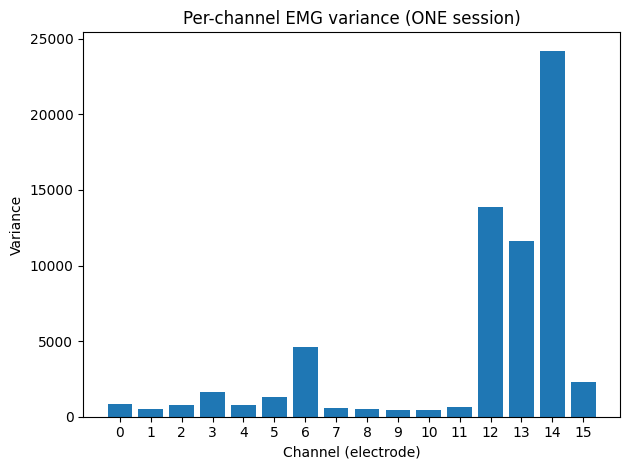

In [21]:
# Verify electrode geometry (16 channels) for spatial part of modeling

# Load one (1!) file and check channel structure
sample_file = pilot_direct.iloc[0]['filename']
fpath = DATA_DIR / f"{sample_file}.hdf5"

with h5py.File(fpath, 'r') as f:
    # Get structured dataset
    ts = f['emg2pose/timeseries']
    # Access specific fields (cols) w/i it
    emg = ts['emg'][:]
    time = ts['time'][:]

print(f"EMG shape: {emg.shape}")  # Should be (T, 16) or (16, T)?
print(f"Time shape: {time.shape}")
print(f"Sample rate: {len(time) / (time[-1] - time[0]):.0f} Hz")
print(f"Duration: {time[-1] - time[0]:.1f} sec")

# Transpose?
if emg.shape[0] == 16:
    emg = emg.T
print(f"EMG (T, C): {emg.shape}")

# Per-channel variance (do channels have different characteristics?)
channel_vars = emg.var(axis=0)
fig, ax = plt.subplots()  # figsize=(10, 3))
ax.bar(range(16), channel_vars)
ax.set_xlabel('Channel (electrode)')
ax.set_ylabel('Variance')
ax.set_title('Per-channel EMG variance (ONE session)')
ax.set_xticks(range(16))
plt.tight_layout()
plt.show()

> SPATIAL INSIGHT
> - Channels have different variance -> geometry encoding may help
> - 16 electrodes arranged circularly around wrist

### Load sessions (filtered) ⏳

In [22]:
%%time
# Electrode spatial verification (ALL filtered sessions)
import h5py
import numpy as np

# Collect per-channel variance for each session
channel_variances = {ch: [] for ch in range(16)}
channel_means = {ch: [] for ch in range(16)}
session_durations = []

print("[Loading all filtered sessions. Please wait...]")
for i, fn in enumerate(pilot_direct['filename'].unique()):
    fpath = DATA_DIR / f"{fn}.hdf5"
    if fpath.exists():
        with h5py.File(fpath, 'r') as f:
            ts = f['emg2pose/timeseries']
            emg = ts['emg'][:]
            time = ts['time'][:]

            # Transpose if needed (ensure T x 16)
            if emg.shape[1] != 16:
                emg = emg.T

            # Store per-channel stats
            for ch in range(16):
                channel_variances[ch].append(emg[:, ch].var())
                channel_means[ch].append(np.abs(emg[:, ch]).mean())

            session_durations.append(time[-1] - time[0])

n_sessions = len(session_durations)
print(f"Processed: {n_sessions} sessions")
print(f"Duration:  {np.mean(session_durations):.1f} ± {np.std(session_durations):.1f} s (mean ± std)")

[Loading all filtered sessions. Please wait...]
Processed: 618 sessions
Duration:  63.2 ± 31.6 s (mean ± std)
CPU times: user 24.8 s, sys: 9.3 s, total: 34.1 s
Wall time: 1min 31s


> High variability in session durations; some sessions much shorter/longer. Note to self: this is fine, but just be aware during windowing. (FYI: 64.7 ± 35.5 s in 10 users.)

### Per-channel variance

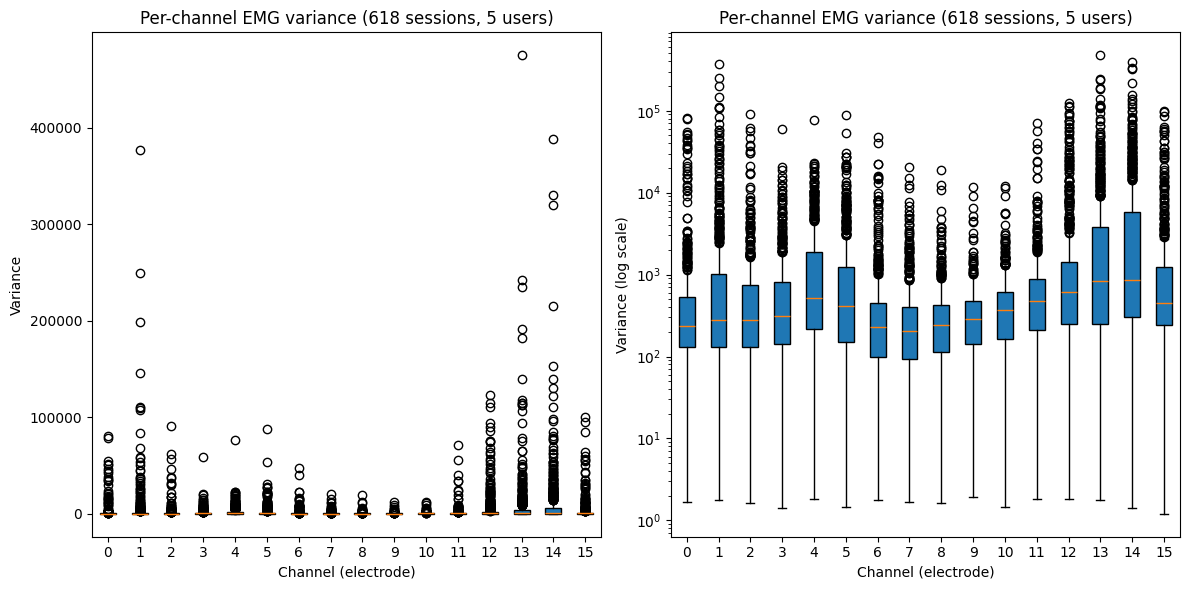

In [23]:
import matplotlib.pyplot as plt

# Per-channel EMG variance boxplots (linear & log scale)
variance_data = [channel_variances[ch] for ch in range(16)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Linear scale (left)
axes[0].boxplot(variance_data, tick_labels=range(16), patch_artist=True)
axes[0].set_xlabel('Channel (electrode)')
axes[0].set_ylabel('Variance')
axes[0].set_title(f'Per-channel EMG variance ({n_sessions} sessions, {N_USERS} users)')

# Log scale (right)
axes[1].boxplot(variance_data, tick_labels=range(16), patch_artist=True)
axes[1].set_xlabel('Channel (electrode)')
axes[1].set_ylabel('Variance (log scale)')
axes[1].set_title(f'Per-channel EMG variance ({n_sessions} sessions, {N_USERS} users)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

Collected 9888 rows (16 channels × 618 sessions)
         user  channel     variance
0  8e69533c16        0   829.141174
1  8e69533c16        1   508.619904
2  8e69533c16        2   779.661194
3  8e69533c16        3  1611.685059
4  8e69533c16        4   747.202209


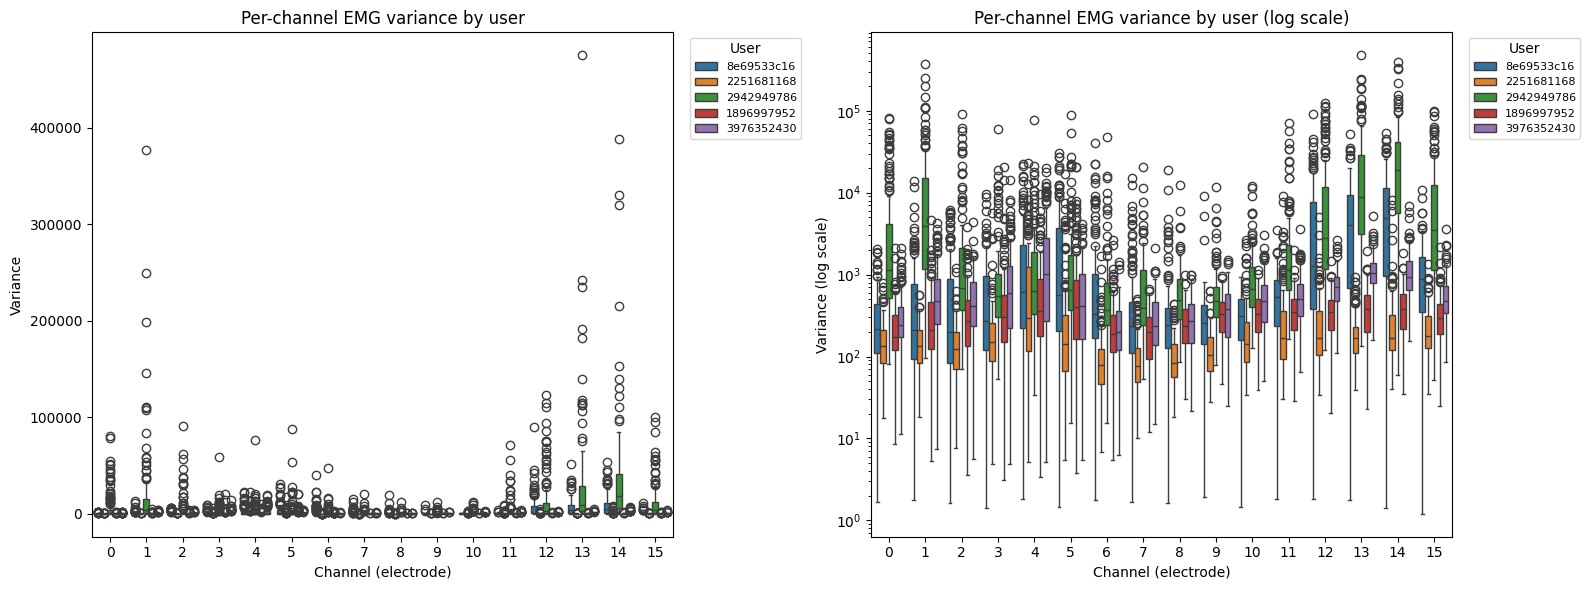

In [24]:
# Collect per-channel variance FOR EACH USER
import pandas as pd

channel_variances_by_user = []

for fn in pilot_direct['filename'].unique():
    fpath = DATA_DIR / f"{fn}.hdf5"
    if fpath.exists():
        # Get user for this file
        user = pilot_direct[pilot_direct['filename'] == fn]['user'].iloc[0]

        with h5py.File(fpath, 'r') as f:
            ts = f['emg2pose/timeseries']
            emg = ts['emg'][:]

            if emg.shape[1] != 16:
                emg = emg.T

            for ch in range(16):
                channel_variances_by_user.append({
                    'user': user,
                    'channel': ch,
                    'variance': emg[:, ch].var()
                })

df_var = pd.DataFrame(channel_variances_by_user)
print(f"Collected {len(df_var)} rows (16 channels × {len(df_var)//16} sessions)")
print(df_var.head())

import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale (left)
sns.boxplot(data=df_var, x='channel', y='variance', hue='user', ax=axes[0])
axes[0].set_xlabel('Channel (electrode)')
axes[0].set_ylabel('Variance')
axes[0].set_title('Per-channel EMG variance by user')
axes[0].legend(title='User', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

# Log scale (right)
sns.boxplot(data=df_var, x='channel', y='variance', hue='user', ax=axes[1])
axes[1].set_xlabel('Channel (electrode)')
axes[1].set_ylabel('Variance (log scale)')
axes[1].set_title('Per-channel EMG variance by user (log scale)')
axes[1].set_yscale('log')
axes[1].legend(title='User', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

### Per-channel mean amplitude

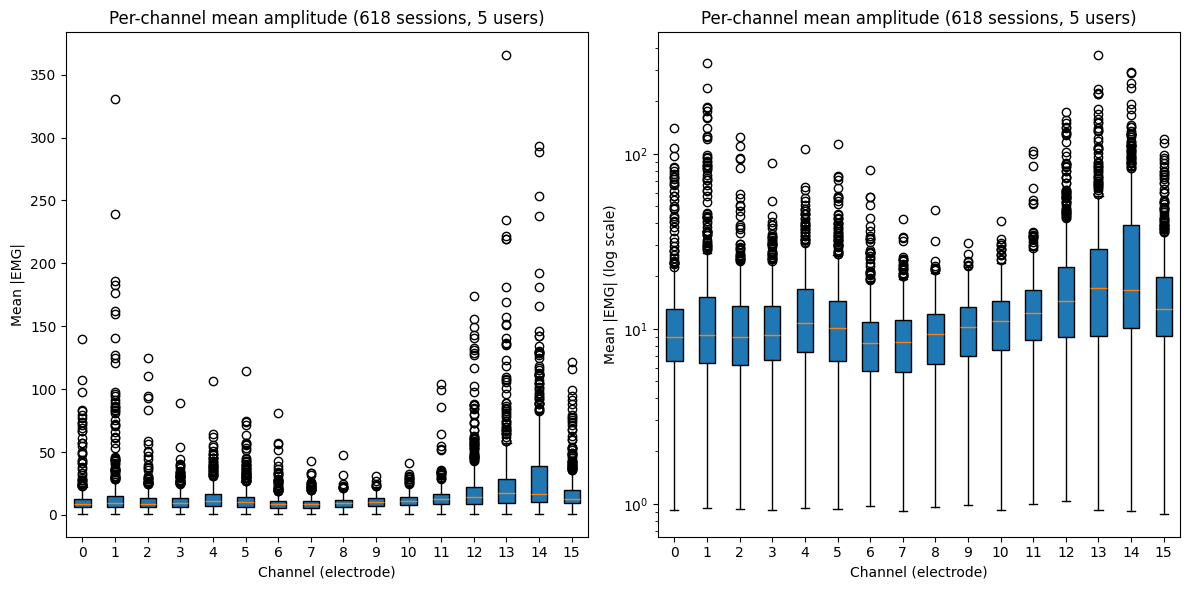

In [25]:
# Per-channel mean amplitude boxplot (linear & log scale)
mean_data = [channel_means[ch] for ch in range(16)]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Linear scale
axes[0].boxplot(mean_data, tick_labels=range(16), patch_artist=True)
axes[0].set_xlabel('Channel (electrode)')
axes[0].set_ylabel('Mean |EMG|')
axes[0].set_title(f'Per-channel mean amplitude ({n_sessions} sessions, {N_USERS} users)')

# Log scale
axes[1].boxplot(mean_data, tick_labels=range(16), patch_artist=True)
axes[1].set_xlabel('Channel (electrode)')
axes[1].set_ylabel('Mean |EMG| (log scale)')
axes[1].set_title(f'Per-channel mean amplitude ({n_sessions} sessions, {N_USERS} users)')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

### Per-user/-channel ⏳

In [26]:
%%time
import pandas as pd
import seaborn as sns

# Collect per-channel, per-user variance & mean
records = []

print("[Loading all filtered sessions. Please wait...]")
for _, row in pilot_direct.iterrows():
    fn = row['filename']
    user = row['user']
    fpath = DATA_DIR / f"{fn}.hdf5"

    if fpath.exists():
        with h5py.File(fpath, 'r') as f:
            ts = f['emg2pose/timeseries']
            emg = ts['emg'][:]

            # Transpose if needed (ensure T x 16)
            if emg.shape[1] != 16:
                emg = emg.T

            # Store per-channel stats w/ user info
            for ch in range(16):
                records.append({
                    'user': user,
                    'channel': ch,
                    'variance': emg[:, ch].var(),
                    'mean_abs': np.abs(emg[:, ch]).mean()
                })

df_stats = pd.DataFrame(records)
print(f"Collected {len(df_stats)} records ({len(df_stats)//16} sessions x 16 channels)")

[Loading all filtered sessions. Please wait...]
Collected 9888 records (618 sessions x 16 channels)
CPU times: user 27.3 s, sys: 8.6 s, total: 35.9 s
Wall time: 1min 33s


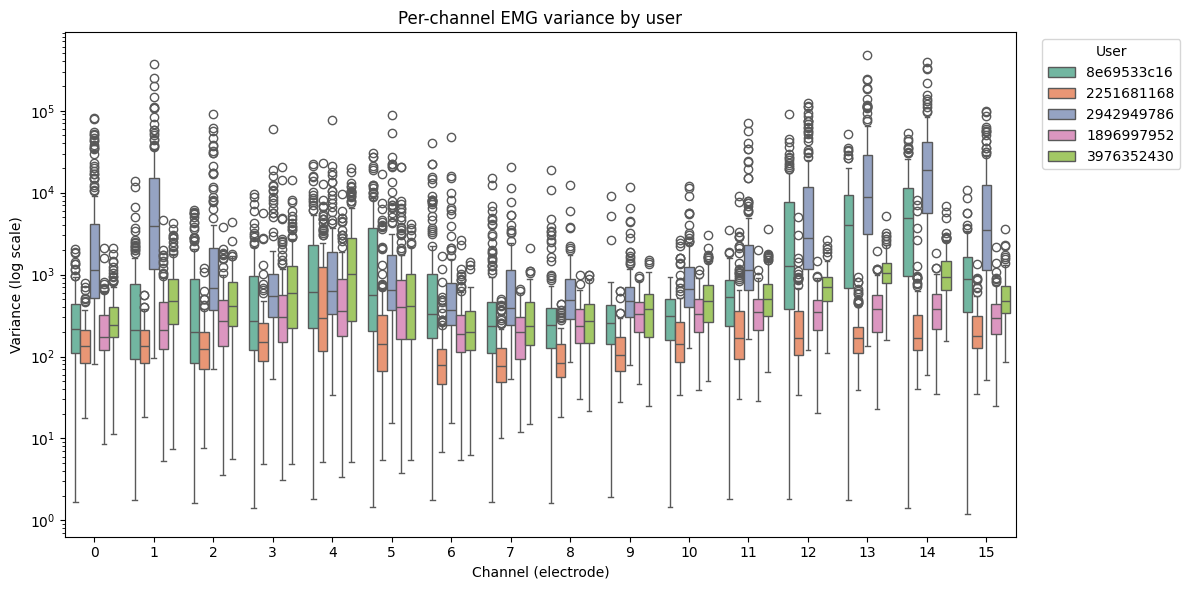

In [27]:
# Per-channel variance by user (log scale)
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    data=df_stats,
    x='channel',
    y='variance',
    hue='user',
    ax=ax,
    palette='Set2'
)

ax.set_yscale('log')
ax.set_xlabel('Channel (electrode)')
ax.set_ylabel('Variance (log scale)')
ax.set_title('Per-channel EMG variance by user')
ax.legend(title='User', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

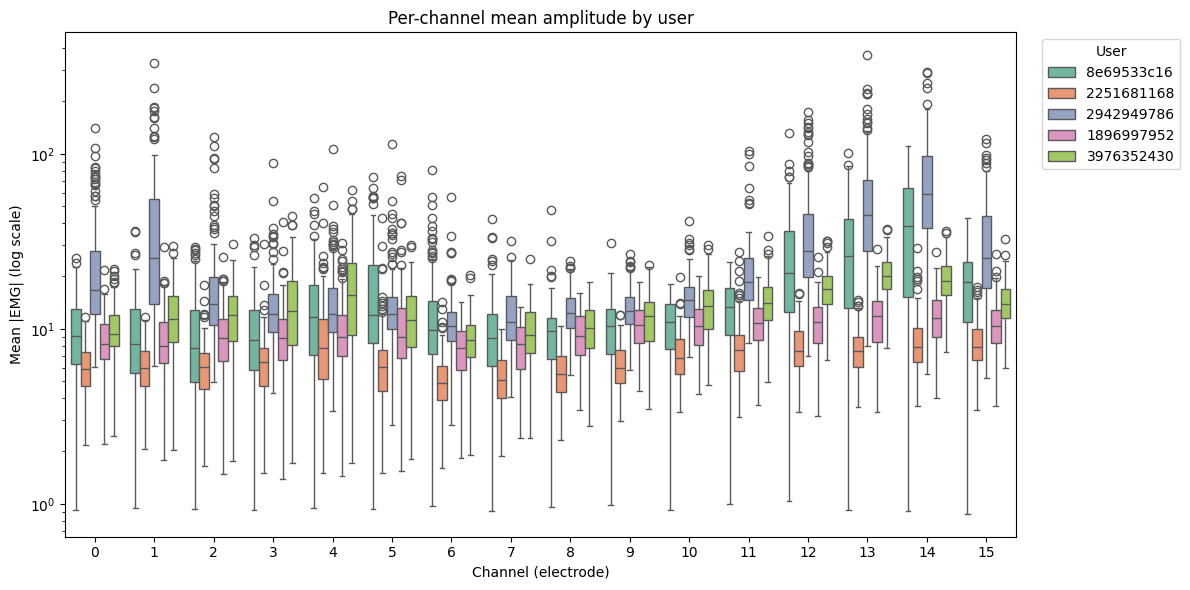

In [28]:
# Per-channel mean amplitude by user (log scale)
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(
    data=df_stats,
    x='channel',
    y='mean_abs',
    hue='user',
    ax=ax,
    palette='Set2'
)

ax.set_yscale('log')
ax.set_xlabel('Channel (electrode)')
ax.set_ylabel('Mean |EMG| (log scale)')
ax.set_title('Per-channel mean amplitude by user')
ax.legend(title='User', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
# Per-user summary (aggregated across channels)
user_summary = df_stats.groupby('user').agg({
    'variance': ['min', 'median', 'max'],
    'mean_abs': ['min', 'median', 'max']
}).round(1)

user_summary.columns = ['var_min', 'var_med', 'var_max', 'mean_min', 'mean_med', 'mean_max']
print("Summary per user (across all channels)")
print(user_summary.to_string())

Summary per user (across all channels)
            var_min     var_med        var_max  mean_min  mean_med    mean_max
user                                                                          
1896997952      3.1  281.200012   20711.000000       1.4       9.5   75.000000
2251681168      4.9  135.899994   23063.099609       1.5       6.4   64.699997
2942949786     15.3  961.200012  475226.093750       2.8      15.6  365.399994
3976352430      4.9  461.700012   19865.400391       1.7      12.6   62.099998
8e69533c16      1.2  405.200012   90182.000000       0.9      11.4  131.000000


> For `PILOT_USERS = ['8e69533c16', '3976352430', '2942949786', '1896997952']`:
> - Large differences in min, median, and max variance across users, especially `2942949786`
> - Global normalization (EMG/std) may be insufficient
> - Consider robust scaling (median or IQR) instead of mean/std?
> - Maybe compare the following later:
>   - Train w/ global normalization (i.e., EMG/std)
>   - Train w/ per-session z-score (benchmark tests on held-out users)
> - *"sEMG is recorded at 2kHz, high pass filtered at 40 Hz, and rescaled such that the noise floor has a standard deviation of 1"* ([Salter, Warren, Schlager, et al. 2024](https://arxiv.org/pdf/2412.02725))

### Summary

In [30]:
# --- Summary stats ---
print(f"--- Per-channel stats (across all sessions, {N_USERS} users) ---")
stats_df = pd.DataFrame({
    'Channel': range(16),
    'Var (median)': [np.median(channel_variances[ch]) for ch in range(16)],
    'Var (IQR)': [np.percentile(channel_variances[ch], 75) - np.percentile(channel_variances[ch], 25) for ch in range(16)],
    'Mean |EMG| (median)': [np.median(channel_means[ch]) for ch in range(16)],
}).round(1)
display(stats_df)

# --- Geometry insight ---
variance_medians = [np.median(channel_variances[ch]) for ch in range(16)]
variance_ratio = max(variance_medians) / min(variance_medians)

print(f"\nVariance ratio (max/min channel): {variance_ratio:.1f}")

--- Per-channel stats (across all sessions, 5 users) ---


,Channel,Var (median),Var (IQR),Mean |EMG| (median)
0,0,236.899994,404.500000,8.900000
1,1,279.899994,900.799988,9.200000
2,2,278.700012,608.000000,9.000000
3,3,312.899994,668.200012,9.200000
4,4,511.399994,1659.900024,10.800000
5,5,414.299988,1102.800049,10.000000
6,6,226.300003,349.000000,8.300000
7,7,206.300003,306.899994,8.400000
8,8,239.100006,315.299988,9.300000
9,9,284.399994,337.299988,10.200000



Variance ratio (max/min channel): 4.2


> For 16 electrodes arranged ~circularly around wrist...
> - If variance ratio is close to 1, all channels contribute ~equally -> suggests maybe don't need spatial factor.
> - If variance ratio > 1 WITH adjacent clustering, may be real anatomical signal -> spatial encoding justified
>   - 4.3-4.8 is modest(?) variance difference -> spatial encoding may have some benefit
> - Channels are NOT equally informative
> - High- and low-var channels are adjacent (e.g., 4-5, 11-15) -> circular structure matters
> - IQR ranges from 317 to 8156 -> Some channels are highly variable across sessions

## EMG & joint angle stats ⏳

In [31]:
%%time
# EMG & joint angle stats (filtered sessions)
emg_mins, emg_maxs, emg_means, emg_stds = [], [], [], []
joint_mins, joint_maxs = [], []

print("[Loading filtered sessions. Please wait...]")
for fn in pilot_direct['filename'].unique():
    fpath = DATA_DIR / f"{fn}.hdf5"
    if fpath.exists():
        with h5py.File(fpath, 'r') as f:
            ts = f['emg2pose/timeseries']
            emg = ts['emg'][:]
            joints = ts['joint_angles'][:]

            emg_mins.append(emg.min())
            emg_maxs.append(emg.max())
            emg_means.append(emg.mean())
            emg_stds.append(emg.std())
            joint_mins.append(joints.min())
            joint_maxs.append(joints.max())

n_files = len(emg_mins)
print(f"Processed: {n_files} sessions")

[Loading filtered sessions. Please wait...]
Processed: 618 sessions
CPU times: user 17.7 s, sys: 11.9 s, total: 29.6 s
Wall time: 1min 24s


In [32]:
print(f"--- EMG stats ({N_USERS} users) ---")
print(f"Range: [{np.min(emg_mins):.1f}, {np.max(emg_maxs):.1f}]")
print(f"Mean: {np.mean(emg_means):.2f}, Std: {np.mean(emg_stds):.2f}")

print(f"\n--- Joint angle stats ({N_USERS} users) ---")
print(f"Range: [{np.min(joint_mins):.3f}, {np.max(joint_maxs):.3f}] rad")

--- EMG stats (5 users) ---
Range: [-7266.6, 7004.9]
Mean: 0.00, Std: 36.40

--- Joint angle stats (5 users) ---
Range: [-1.754, 3.009] rad


> PREPROCESSING INSIGHTS
> - EMG: Consider applying z-score normalization because data is centered but has large range
> - Joints: Already in radians, no normalization needed

## Train/val/test split

In [ ]:
# Train/val/test split using original dataset splits

# Split distribution (filtered data)
print("--- Split Distribution (pilot_direct) ---")
print(pilot_direct['split'].value_counts())

# Use original splits
train_data = pilot_direct[pilot_direct['split'] == 'train']
val_data = pilot_direct[pilot_direct['split'] == 'val']
test_data = pilot_direct[pilot_direct['split'] == 'test']

print(f"\n--- Original dataset splits ---")
print(f"Train: {len(train_data):,} samples")
print(f"Val:   {len(val_data):,} samples")
print(f"Test:  {len(test_data):,} samples")

# Generalization breakdown
print(f"\n--- Generalization types (for evaluation) ---")
print(pilot_direct['generalization'].value_counts())

# Estimate windows
WINDOW_SEC = 1.0
AVG_DURATION_SEC = np.mean(session_durations)  # From EDA output

windows_per_file = AVG_DURATION_SEC / WINDOW_SEC

print(f"\n--- Estimated training windows ---")
print(f"Avg duration: {AVG_DURATION_SEC:.1f} sec")
print(f"Windows per file: {windows_per_file:.0f}")
print(f"Total train windows: {len(train_data) * windows_per_file:,.0f}")
print(f"Total val windows: {len(val_data) * windows_per_file:,.0f}")

# Deep learning adequacy check
total_train_windows = len(train_data) * windows_per_file

--- Split Distribution (pilot_direct) ---
split
train    406
val      117
test      95
Name: count, dtype: int64

--- Original dataset splits ---
Train: 406 samples
Val:   117 samples
Test:  95 samples

--- Generalization types (for evaluation) ---
generalization
none          406
stage          95
user           93
user_stage     24
Name: count, dtype: int64

--- Estimated training windows ---
Avg duration: 63.2 sec
Windows per file: ~63
Total train windows: ~25,643
Total val windows: ~7,390


> Given:
> - `TRAIN_USERS = ['8e69533c16', '3976352430', '2942949786', '1896997952']`
> - `VAL_USERS = ['2251681168']`
> - `PILOT_USERS = TRAIN_USERS + VAL_USERS`
> - `TEST_USERS = ['7e08fa55fd']`
>
> Here is our setup for development:
> - Training: 25,643 windows for architecture iteration
> - Validation: 7,390 windows for user generalization signal
> - Test: 5,997 windows for stage generalization signal
>
> This should allow us to evaluate:
> - User generalization (val split: 93 samples)
> - Stage generalization (test split: 95 samples)
> - User+stage generalization (24 samples in val)
